In [1]:
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
now = datetime.now()
time_str = now.strftime("%Y-%m-%d-%H-%M-%S")

# Options

In [3]:
data_root = '../data/'
run_root = './runs/'
run_path = os.path.join(run_root, time_str)
which_device = 'cpu'

In [4]:
if not os.path.exists(run_path):
    os.makedirs(run_path)
    
myhost = os.uname()[1]
print('Hostname: ' + myhost)

if which_device == 'gpu' and torch.cuda.is_available():
    device_names = [torch.cuda.get_device_name(device=i) for i in range(torch.cuda.device_count())]
    tesla_idx = [dn.find('Tesla') for dn in device_names].index(0)
    device = torch.device("cuda:{}".format(tesla_idx))
print('Selected Device: ' + torch.cuda.get_device_name(torch.cuda.current_device()))

Hostname: D-01253-Arch
Selected Device: Tesla K20c


/home/drawitschf/.conda/envs/gen-EM/lib/python3.8/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU1 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


# Dataset

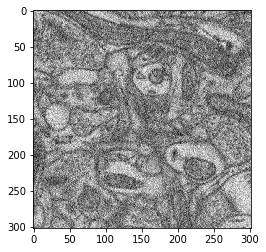

In [5]:
# Let's look at some data
img = plt.imread(os.path.join(data_root, '2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif'))
plt.imshow(img, cmap='gray');

In [6]:
# Let's get a quick-and-dirty estimate of image summary stats
norm_params = {'mean': np.mean(img), 'std': np.std(img)}

## Define Dataset subclass

In [7]:
class SBEMCrop2dDataset(Dataset):
    
    def __init__(self, data_root, norm_params):
        self.data_fnames = os.listdir(data_root)
        self.data_root = data_root
        self.norm_params = norm_params
    
    def __len__(self):
        return len(self.data_fnames)
    
    def __getitem__(self, idx):
        img = np.asarray(plt.imread(os.path.join(self.data_root, self.data_fnames[idx])))
        img = self._normalize(img)
        sample = SBEMCrop2dDataset._reshape_to_torch(img)
        return sample
    
    def _normalize(self, img):
        img = (np.asarray(img)-self.norm_params['mean'])/self.norm_params['std']
        return img
    
    @staticmethod
    def _reshape_to_torch(img):
        sample = torch.from_numpy(np.reshape(img, (1, img.shape[0], img.shape[1]))).float()
        return sample

## Instantiate dataset subclass

In [8]:
sbem_dataset = SBEMCrop2dDataset(data_root, norm_params)
len(sbem_dataset)

60

## Test dataset subclass

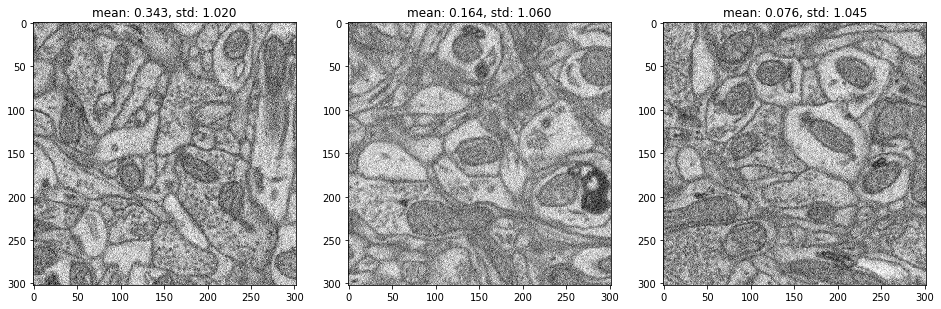

In [9]:
# Show first 3 images in dataset
fig, axs = plt.subplots(1, 3, figsize=(16,12))

for i in range(3):
    sample = sbem_dataset[i]
    img = sample.data.numpy().squeeze()
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title('mean: {:0.3f}, std: {:0.3f}'.format(np.mean(img), np.std(img)))

# Model

## Define Model

In [10]:
def get_conv_pad(input_size, kernel_size, stride):
    padding = np.ceil(((stride-1)*input_size-stride+kernel_size)/2).astype(int)
    return padding

In [11]:
class Encoder_3_sampling_bn(torch.nn.Module):
    
    def __init__(self, input_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.encoding_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, n_fmaps, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
    
        self.encoding_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*2, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_fc = torch.nn.Sequential(
            torch.nn.Linear(36**2*n_fmaps*4, n_latent),
            torch.nn.ReLU())
        
    def forward(self, x):
        
        x = self.encoding_conv1(x)
        x = self.encoding_conv2(x)
        x = self.encoding_conv3(x)
        x = self.encoding_fc(x.reshape((-1, 1, 36**2*n_fmaps*4)))
        
        return x

In [12]:
class Decoder_3_sampling_bn(torch.nn.Module):
    
    def __init__(self, output_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.decoding_fc = torch.nn.Sequential(
            torch.nn.Linear(n_latent, 36**2*n_fmaps*4),
            torch.nn.ReLU())
        
        self.decoding_convt1 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*4, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU())
        
        self.decoding_convt2 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*2, n_fmaps, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps),
            torch.nn.ReLU())
        
        self.decoding_convt3 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps, 1, kernel_size, stride))
        
    def forward(self, x):
        
        x = self.decoding_fc(x)
        x = self.decoding_convt1(x.reshape((-1, n_fmaps*4, 36, 36)))
        x = self.decoding_convt2(x)
        x = self.decoding_convt3(x)
        
        return x

In [13]:
class AE(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Instantiate Model, Loss and Optimizer

In [14]:
input_size=302
output_size=input_size
valid_size = 17
input_center = int(np.floor(input_size/2))
valid_width = int(np.floor(valid_size/2))
kernel_size=3
stride=1
n_fmaps=8
n_latent=750
net = AE(
    Encoder_3_sampling_bn(input_size, kernel_size, stride, n_fmaps, n_latent), 
    Decoder_3_sampling_bn(output_size, kernel_size, stride, n_fmaps, n_latent))
if which_device == 'gpu':
    net.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.8)

## Utility functions

In [15]:
def data2fig_subplot(inputs, outputs, idx):
    fig, axs = plt.subplots(1, 2, figsize=(16,12))
    img_input = inputs[idx].data.numpy().squeeze()
    axs[0].imshow(img_input, cmap='gray')
    img_output = outputs[idx].data.numpy().squeeze()
    axs[1].imshow(img_output, cmap='gray')
    return fig

In [16]:
def crop_valid(tensor, center, width):
    valid_tensor = tensor[:, 0:1, center-width:center+width+1, center-width:center+width+1]
    return valid_tensor

# Train Model

In [17]:
trainloader = DataLoader(sbem_dataset, batch_size=10, shuffle=True, num_workers=6)
writer = SummaryWriter(run_path)
writer_int = 5
n_epoch = 500
it = 0

if which_device == 'gpu':
    print('training on gpu')
else:
    print('training on cpu')
    

for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        it += 1
        
        if which_device == 'gpu':
            inputs = data.to(device)
            labels = data.clone().to(device)
        else :
            inputs = data
            labels = data.clone()

#         data = trainloader.dataset[0]
#         inputs = data.unsqueeze(0)
#         labels = data.clone().unsqueeze(0)
        
#         labels_valid = crop_valid(labels, input_center, valid_width)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         outputs_valid = crop_valid(outputs, input_center, valid_width)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics 
        running_loss += loss.item()
        if (i+1) % writer_int == 0:

            print('it: {} (epoch: {}, batch: {}), running loss: {:0.3f}'.format(i, epoch, i+1, running_loss))

            writer.add_scalar('loss', loss.item(), it)
            writer.add_scalar('running_loss', running_loss, it)
            writer.add_figure('inputs', data2fig_subplot(inputs, outputs, 0), it)

            running_loss = 0.0

training on cpu
it: 4 (epoch: 0, batch: 5), running loss: 7.897
it: 4 (epoch: 1, batch: 5), running loss: 6.254
it: 4 (epoch: 2, batch: 5), running loss: 5.974
it: 4 (epoch: 3, batch: 5), running loss: 5.868
it: 4 (epoch: 4, batch: 5), running loss: 5.812
it: 4 (epoch: 5, batch: 5), running loss: 5.773
it: 4 (epoch: 6, batch: 5), running loss: 5.779
it: 4 (epoch: 7, batch: 5), running loss: 5.746
it: 4 (epoch: 8, batch: 5), running loss: 5.711
it: 4 (epoch: 9, batch: 5), running loss: 5.721
it: 4 (epoch: 10, batch: 5), running loss: 5.708
it: 4 (epoch: 11, batch: 5), running loss: 5.682
it: 4 (epoch: 12, batch: 5), running loss: 5.657
it: 4 (epoch: 13, batch: 5), running loss: 5.679
it: 4 (epoch: 14, batch: 5), running loss: 5.663
it: 4 (epoch: 15, batch: 5), running loss: 5.667
it: 4 (epoch: 16, batch: 5), running loss: 5.684
it: 4 (epoch: 17, batch: 5), running loss: 5.666
it: 4 (epoch: 18, batch: 5), running loss: 5.651
it: 4 (epoch: 19, batch: 5), running loss: 5.641
it: 4 (epoch: 

it: 4 (epoch: 166, batch: 5), running loss: 3.824
it: 4 (epoch: 167, batch: 5), running loss: 3.813
it: 4 (epoch: 168, batch: 5), running loss: 3.837
it: 4 (epoch: 169, batch: 5), running loss: 3.807
it: 4 (epoch: 170, batch: 5), running loss: 3.806
it: 4 (epoch: 171, batch: 5), running loss: 3.791
it: 4 (epoch: 172, batch: 5), running loss: 3.798
it: 4 (epoch: 173, batch: 5), running loss: 3.784
it: 4 (epoch: 174, batch: 5), running loss: 3.778
it: 4 (epoch: 175, batch: 5), running loss: 3.798
it: 4 (epoch: 176, batch: 5), running loss: 3.774
it: 4 (epoch: 177, batch: 5), running loss: 3.775
it: 4 (epoch: 178, batch: 5), running loss: 3.767
it: 4 (epoch: 179, batch: 5), running loss: 3.762
it: 4 (epoch: 180, batch: 5), running loss: 3.758
it: 4 (epoch: 181, batch: 5), running loss: 3.755
it: 4 (epoch: 182, batch: 5), running loss: 3.750
it: 4 (epoch: 183, batch: 5), running loss: 3.754
it: 4 (epoch: 184, batch: 5), running loss: 3.774
it: 4 (epoch: 185, batch: 5), running loss: 3.736


it: 4 (epoch: 330, batch: 5), running loss: 3.423
it: 4 (epoch: 331, batch: 5), running loss: 3.439
it: 4 (epoch: 332, batch: 5), running loss: 3.430
it: 4 (epoch: 333, batch: 5), running loss: 3.428
it: 4 (epoch: 334, batch: 5), running loss: 3.424
it: 4 (epoch: 335, batch: 5), running loss: 3.424
it: 4 (epoch: 336, batch: 5), running loss: 3.413
it: 4 (epoch: 337, batch: 5), running loss: 3.418
it: 4 (epoch: 338, batch: 5), running loss: 3.430
it: 4 (epoch: 339, batch: 5), running loss: 3.428
it: 4 (epoch: 340, batch: 5), running loss: 3.429
it: 4 (epoch: 341, batch: 5), running loss: 3.417
it: 4 (epoch: 342, batch: 5), running loss: 3.416
it: 4 (epoch: 343, batch: 5), running loss: 3.407
it: 4 (epoch: 344, batch: 5), running loss: 3.422
it: 4 (epoch: 345, batch: 5), running loss: 3.405
it: 4 (epoch: 346, batch: 5), running loss: 3.416
it: 4 (epoch: 347, batch: 5), running loss: 3.417
it: 4 (epoch: 348, batch: 5), running loss: 3.401
it: 4 (epoch: 349, batch: 5), running loss: 3.409


it: 4 (epoch: 494, batch: 5), running loss: 3.250
it: 4 (epoch: 495, batch: 5), running loss: 3.249
it: 4 (epoch: 496, batch: 5), running loss: 3.249
it: 4 (epoch: 497, batch: 5), running loss: 3.249
it: 4 (epoch: 498, batch: 5), running loss: 3.245
it: 4 (epoch: 499, batch: 5), running loss: 3.244


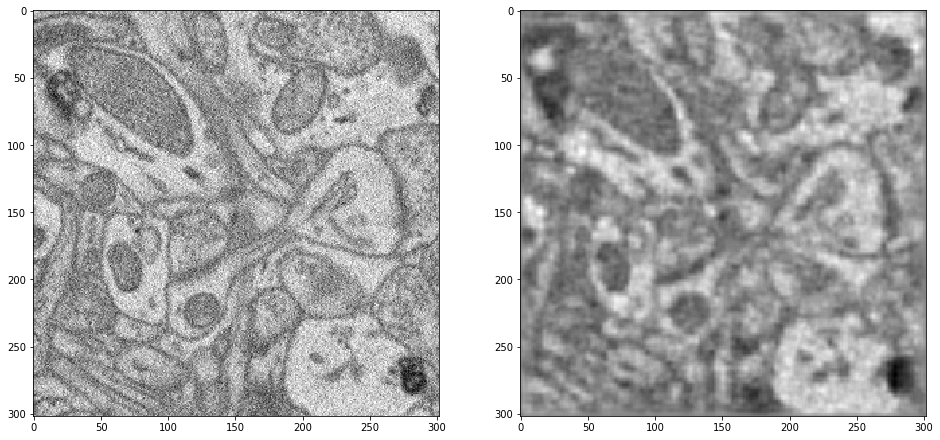

In [27]:
# Show input vs output
data2fig_subplot(inputs, outputs, 6);

(array([  128.,   949.,  7582., 18680., 22444., 17177., 11231.,  8799.,
         3960.,   254.]),
 array([-1.7719618 , -1.3395857 , -0.9072095 , -0.4748334 , -0.04245727,
         0.38991886,  0.822295  ,  1.2546711 ,  1.6870472 ,  2.1194234 ,
         2.5517995 ], dtype=float32),
 <a list of 10 Patch objects>)

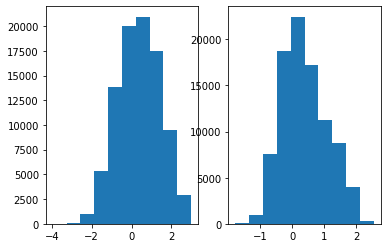

In [19]:
fig, axs = plt.subplots(1,2)
axs[0].hist(inputs[0].data.numpy().flatten())
axs[1].hist(outputs[0].data.numpy().flatten())

In [21]:
torch.save(net.state_dict(), os.path.join(run_path, 'model'))